# Introduction

This report is to investigate the following questions:

* What are the main factors affecting mortality of patients with cirrhosis?

# Data Import

In [73]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [95]:
# load data
Cirrhosis_DS0 = pd.read_csv('/Users/mengphilshen/Dropbox/Project/Data_Challenges/Proj_Cirrhosis/data/cir_mortality.csv')
Cirrhosis_DS0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86432 entries, 0 to 86431
Data columns (total 31 columns):
VISIT_ID2                   86432 non-null int64
MORTALITY                   86432 non-null int64
AKI_CATEGORY2               86432 non-null object
ARDS                        86432 non-null object
ABX                         86432 non-null int64
BETA_BLOCKER                86432 non-null int64
CRYST_RES_VOL_CATEGORY      86432 non-null object
DIURETIC                    86432 non-null int64
GIDX_BLEEDING               86432 non-null int64
GLYCEMIA                    86432 non-null object
HE                          86432 non-null int64
HRS                         86432 non-null int64
LVP                         86432 non-null int64
SBP                         86432 non-null int64
SEPSIS                      86432 non-null int64
STEROIDS                    86432 non-null int64
TIME_TO_ALB_CATEGORY_LOS    86432 non-null object
VENTILATION                 86432 non-null int64
VASO

In [87]:
# set index
Cirrhosis_DS0.set_index(['VISIT_ID2'], inplace = True)

# Data Cleaning

## Delete Missing Values

In [88]:
# check missing values
missing_data = Cirrhosis_DS0.isnull().sum(axis = 0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['missing %'] = missing_data['missing values'] / Cirrhosis_DS0.shape[0] * 100
missing_data_srt = missing_data.sort_values('missing %', ascending = False).reset_index(drop = True)
missing_data_srt[missing_data_srt['missing %'] > 0]

,variable,missing values,missing %
0,MELD_Na,3226,3.732414
1,ELIXHAUSER_INDEX,32,0.037023


In [172]:
# delete missing values
Cirrhosis_DS1 = Cirrhosis_DS0.dropna()
Cirrhosis_DS1.shape

(83179, 31)

## Encode Categorical Features

In [91]:
# convert feature types
Cirrhosis_DS1['INDEX_YEAR'] = Cirrhosis_DS1['INDEX_YEAR'].apply(str)

In [174]:
# encode categorical features
Cirrhosis_DS2 = pd.get_dummies(Cirrhosis_DS1)
Cirrhosis_DS2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83179 entries, 0 to 86431
Data columns (total 69 columns):
VISIT_ID2                             83179 non-null int64
MORTALITY                             83179 non-null int64
ABX                                   83179 non-null int64
BETA_BLOCKER                          83179 non-null int64
DIURETIC                              83179 non-null int64
GIDX_BLEEDING                         83179 non-null int64
HE                                    83179 non-null int64
HRS                                   83179 non-null int64
LVP                                   83179 non-null int64
SBP                                   83179 non-null int64
SEPSIS                                83179 non-null int64
STEROIDS                              83179 non-null int64
VENTILATION                           83179 non-null int64
VASOPRESSOR                           83179 non-null int64
FEMALE                                83179 non-null int64
INDEX_

In [93]:
# drop one level to avoid collinearity
variables_to_drop = ['AKI_CATEGORY2_NONE', 
                     'ARDS_NONE', 
                     'CRYST_RES_VOL_CATEGORY_>1250', 
                     'GLYCEMIA_NEITHER', 
                     'TIME_TO_ALB_CATEGORY_LOS_NONE', 
                     'ADMISSION_TYPE_GROUP_Emergency', 
                     'AGE_GROUP_18-29', 
                     'BED_SIZE_0-99', 
                     'CENSUS_REGION_South', 
                     'INDEX_YEAR_2016',
                     'PAYER_GROUP_Commercial', 
                     'RACE_GROUP_Caucasian', 
                     'TEACHING_FACILITY_No']
Cirrhosis_DS3 = Cirrhosis_DS2.drop(variables_to_drop, axis = 1)
Cirrhosis_DS3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83179 entries, 326305398 to 283396498
Data columns (total 62 columns):
MORTALITY                             83179 non-null int64
ABX                                   83179 non-null int64
BETA_BLOCKER                          83179 non-null int64
DIURETIC                              83179 non-null int64
GIDX_BLEEDING                         83179 non-null int64
HE                                    83179 non-null int64
HRS                                   83179 non-null int64
LVP                                   83179 non-null int64
SBP                                   83179 non-null int64
SEPSIS                                83179 non-null int64
STEROIDS                              83179 non-null int64
VENTILATION                           83179 non-null int64
VASOPRESSOR                           83179 non-null int64
FEMALE                                83179 non-null int64
RURAL                                 83179 non-null 

## Seperate Features and Targets

In [96]:
# create the target vector
y = Cirrhosis_DS3.iloc[:, Cirrhosis_DS3.columns == 'MORTALITY']
y['MORTALITY'].value_counts()

0    74275
1     8904
Name: MORTALITY, dtype: int64

In [97]:
y['MORTALITY'].value_counts(normalize = True)

0    0.892954
1    0.107046
Name: MORTALITY, dtype: float64

In [98]:
# create the features matrix
X = Cirrhosis_DS3.iloc[:, Cirrhosis_DS3.columns != 'MORTALITY']
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ABX,83179.0,0.616382,0.486270,0.0,0.0,1.0,1.0,1.0
BETA_BLOCKER,83179.0,0.164092,0.370361,0.0,0.0,0.0,0.0,1.0
DIURETIC,83179.0,0.440436,0.496442,0.0,0.0,0.0,1.0,1.0
GIDX_BLEEDING,83179.0,0.144964,0.352067,0.0,0.0,0.0,0.0,1.0
HE,83179.0,0.192188,0.394022,0.0,0.0,0.0,0.0,1.0
HRS,83179.0,0.045576,0.208566,0.0,0.0,0.0,0.0,1.0
LVP,83179.0,0.264526,0.441083,0.0,0.0,0.0,1.0,1.0
SBP,83179.0,0.035838,0.185888,0.0,0.0,0.0,0.0,1.0
SEPSIS,83179.0,0.110785,0.313868,0.0,0.0,0.0,0.0,1.0
STEROIDS,83179.0,0.137883,0.344780,0.0,0.0,0.0,0.0,1.0


## Data Summary

* **83,179** unique patient visits with cirrhosis in total. 


* **Outcome:** 8,904 (10.7%) visits would pass away in hospital. 


* **Features**:  

  + Acute Kidney Injury (categorical)
  
  + Acute Respiratory Distress Syndrome (categorical)

  + Antibiotics (binary)
 
  + Beta Blockers (binary)
  
  + Volume of Crystalloids for Resuscitation (categorical)
  
  + Diuretics (binary)
  
  + Glucose Levels (binary)
  
  + Hepatic Encephalopathy (binary)
  
  + Hepatorenal Syndrome (binary)
  
  + Large Volume Paracentesis (binary)
  
  + Spontaneous Bacterial Peritonitis (binary)
  
  + Sepsis (binary)
  
  + Steroids (binary)
  
  + Time to Albumin (categorical)
  
  + Mechanical Ventilation (categorical)
  
  + Vasopressors (categorical)
  
  + Elixhauser Index (continuous)
  
  + MELD-Na Score (continuous)
  
  + Admission Type (categorical)
  
  + Age Group (categorical)
  
  + Bed Size (categorical)
  
  + Region (categorical)
  
  + Gender (binary)
  
  + Year (categorical)
  
  + Payer (categorical)
  
  + Race (categorical)
  
  + Teaching Facility (categorical)
  
  + Urban_Rural (binary)


# Generalized Linear Model - Logistic Regression

## Fit Classical Logistic Regression

In [99]:
# create a logistic regression model
X_cons = sm.add_constant(X)
glm_logit = sm.Logit(y, X_cons)

In [100]:
# fit logistic regression
glm_logit_result = glm_logit.fit()

Optimization terminated successfully.
         Current function value: 0.218575
         Iterations 8


In [101]:
# display model summary
print(glm_logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:              MORTALITY   No. Observations:                83179
Model:                          Logit   Df Residuals:                    83117
Method:                           MLE   Df Model:                           61
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                  0.3577
Time:                        13:30:24   Log-Likelihood:                -18181.
converged:                       True   LL-Null:                       -28305.
                                        LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -5.6010      0.149    -37.472      0.000      -5.894      -5.308
ABX                                   -0.0511      0.033   

## GLM Model Summary

The GLM Model shows the following features are **statistical significant**:

  + **Acute Kidney Injury (categorical)**
  
  + **Acute Respiratory Distress Syndrome (categorical)**

  + Antibiotics (binary)
 
  + **Beta Blockers (binary)**
  
  + **Volume of Crystalloids for Resuscitation (categorical)**
  
  + **Diuretics (binary)**
  
  + **GI Bleeding (binary)**
  
  + **Glucose Levels (categorical)**
  
  + **Hepatic Encephalopathy (binary)**
  
  + **Hepatorenal Syndrome (binary)**
  
  + **Large Volume Paracentesis (binary)**
  
  + **Spontaneous Bacterial Peritonitis (binary)**
  
  + **Sepsis (binary)**
  
  + **Steroids (binary)**
  
  + **Time to Albumin (categorical)**
  
  + **Mechanical Ventilation (categorical)**
  
  + **Vasopressors (binary)**
  
  + **Elixhauser Index (binary)**
  
  + **MELD-Na Score (continuous)**
  
  + **Admission Type (categorical)**
  
  + **Age Group (categorical)**
  
  + **Bed Size (categorical)**
  
  + **Region (categorical)**
  
  + **Gender (binary)**
  
  + **Year (categorical)**
  
  + **Payer (categorical)**
  
  + **Race (categorical)**
  
  + **Teaching Facility (categorical)**
  
  + **Urban_Rural (binary)**

# Split Data into Training and Test Sets

In [104]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 12345)
print('Training Features Shape:', X_train.shape)
print('Training Lable Shape:', y_train.shape)
print('Test Features Shape:', X_test.shape)
print('Test Lable Shape:', y_test.shape)

Training Features Shape: (58225, 61)
Training Lable Shape: (58225, 1)
Test Features Shape: (24954, 61)
Test Lable Shape: (24954, 1)


In [105]:
# fit standardizer to training set
standardizer = StandardScaler()
standardizer.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [106]:
# apply to both training and test sets
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

In [107]:
# covert labels to arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Machine Learning Model - Logistic Regression

## Train Model

In [108]:
# create a base Logistic model
base_logit = LogisticRegression(class_weight = 'balanced', random_state = 12345)

In [109]:
# train the model on training data
base_logit.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2',
          random_state=12345, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

## Predict Test Data

In [110]:
# predict test data
y_pred_logit = base_logit.predict(X_test_std)
y_pred_prob_logit = base_logit.predict_proba(X_test_std)

## Evaulate Performance

Please refer to this [wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) link for better undertanding performance metrics

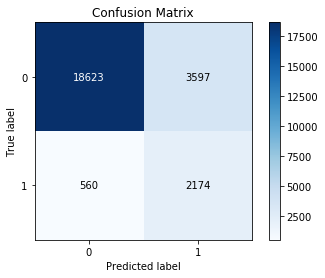

In [111]:
# plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_logit)
plt.show()

In [181]:
# calculate proformance metrics
cm_matrix = confusion_matrix(y_test, y_pred_logit)
tn, fp, fn, tp = cm_matrix.ravel()
accuracy = (tn+tp)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp /(tp+fn)
f1 = (2*precision*recall)/(precision+recall)
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)
print("Accuracy: {:0.2f}:".format(accuracy))
print("Precision: {:0.2f}:".format(precision))
print("Recall: {:0.2f}:".format(recall))
print("F1 Score: {:0.2f}:".format(f1))

True Negatives:  18623
False Positives:  3597
False Negatives:  560
True Positives:  2174
Accuracy: 0.83:
Precision: 0.38:
Recall: 0.80:
F1 Score: 0.51:


In [117]:
# print classification report
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     22220
           1       0.38      0.80      0.51      2734

   micro avg       0.83      0.83      0.83     24954
   macro avg       0.67      0.82      0.71     24954
weighted avg       0.91      0.83      0.86     24954



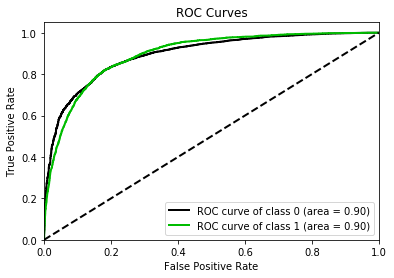

In [118]:
# plot ROC curves
skplt.metrics.plot_roc_curve(y_test, y_pred_prob_logit, curves = ('each_class'))
plt.show()

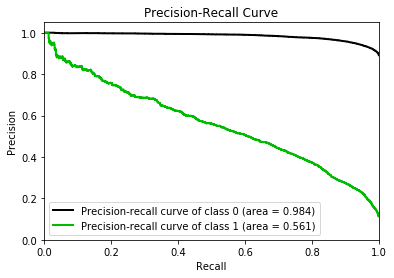

In [119]:
# plot Precision-Recall curve
skplt.metrics.plot_precision_recall_curve(y_test, y_pred_prob_logit, curves = ('each_class'))
plt.show()

In [187]:
# store proformance metrics
col_names = ['Model', 'Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC', 'Precision-Recall AUC']
metrics = pd.DataFrame(columns = col_names)
logit_metric = {'Model': 'Logistic Regression', 'Precision': 0.38, 'Recall': 0.80, 
                'F1': 0.51, 'Accuracy': 0.83, 'ROC AUC': 0.90, 'Precision-Recall AUC': 0.56}
metrics.loc[len(metrics)] = logit_metric
metrics

,Model,Precision,Recall,F1,Accuracy,ROC AUC,Precision-Recall AUC
0,Logistic Regression,0.38,0.8,0.51,0.83,0.9,0.56


# Machine Learning Model - Random Forests

## Train Model

In [120]:
# create a base Random Forest model
base_rf = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced', random_state = 12345)

In [121]:
# train the model on training data
base_rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=12345, verbose=0, warm_start=False)

## Predict Test Data

In [122]:
# predict test data
y_pred_rf = base_rf.predict(X_test_std)
y_pred_prob_rf = base_rf.predict_proba(X_test_std)

## Evaulate Performance

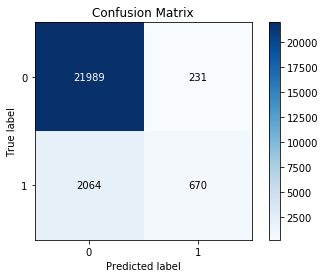

In [123]:
# plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf)
plt.show()

In [185]:
# calculate proformance metrics
cm_matrix = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm_matrix.ravel()
accuracy = (tn+tp)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp /(tp+fn)
f1 = (2*precision*recall)/(precision+recall)
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)
print("Accuracy: {:0.2f}:".format(accuracy))
print("Precision: {:0.2f}:".format(precision))
print("Recall: {:0.2f}:".format(recall))
print("F1 Score: {:0.2f}:".format(f1))

True Negatives:  21989
False Positives:  231
False Negatives:  2064
True Positives:  670
Accuracy: 0.91:
Precision: 0.74:
Recall: 0.25:
F1 Score: 0.37:


In [179]:
# print classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     22220
           1       0.74      0.25      0.37      2734

   micro avg       0.91      0.91      0.91     24954
   macro avg       0.83      0.62      0.66     24954
weighted avg       0.90      0.91      0.89     24954



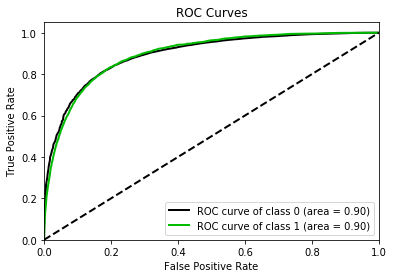

In [130]:
# plot ROC curves
skplt.metrics.plot_roc_curve(y_test, y_pred_prob_rf, curves = ('each_class'))
plt.show()

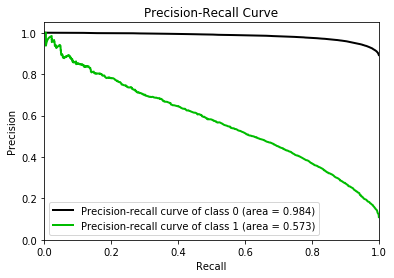

In [131]:
# plot Precision-Recall curve
skplt.metrics.plot_precision_recall_curve(y_test, y_pred_prob_rf, curves = ('each_class'))
plt.show()

In [188]:
# store proformance metrics
rf_metric = {'Model': 'Random Forests', 'Precision': 0.74, 'Recall': 0.25, 
                'F1': 0.37, 'Accuracy': 0.91, 'ROC AUC': 0.90, 'Precision-Recall AUC': 0.57}
metrics.loc[len(metrics)] = rf_metric
metrics

,Model,Precision,Recall,F1,Accuracy,ROC AUC,Precision-Recall AUC
0,Logistic Regression,0.38,0.80,0.51,0.83,0.9,0.56
1,Random Forests,0.74,0.25,0.37,0.91,0.9,0.57


## Examine Variable Importances

In [132]:
# create a dataframe of feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
feature_importances['importance'] = base_rf.feature_importances_
feature_importances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
feature       61 non-null object
importance    61 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [191]:
# sort dataframe by feature importances
feature_importances_srt = feature_importances.sort_values(by='importance', ascending = False).reset_index()
feature_importances_srt

,index,feature,importance
0,15,MELD_Na,0.120714
1,11,VASOPRESSOR,0.078029
2,14,ELIXHAUSER_INDEX,0.074417
3,8,SEPSIS,0.072919
4,10,VENTILATION,0.072602
5,16,AKI_CATEGORY2_MILD,0.040662
6,17,AKI_CATEGORY2_SEVERE,0.035837
7,20,ARDS_SEVERE ARDS,0.023840
8,28,TIME_TO_ALB_CATEGORY_LOS_>24,0.021648
9,12,FEMALE,0.014407


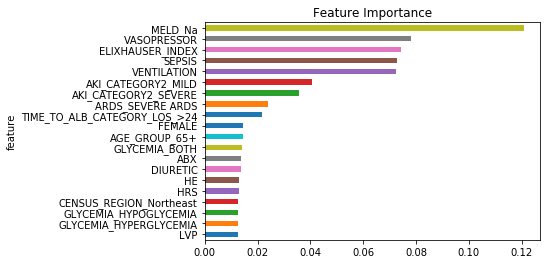

In [192]:
# plot Top 20 feature importances
feature_importances_top20 = feature_importances_srt.iloc[0:20, :]
feature_importances_top20.sort_values(by='importance', ascending = True, inplace = True)
feature_importances_top20.plot(x = 'feature', y = 'importance', kind = 'barh', legend = False)
plt.title('Feature Importance')
plt.show()

## Machine Learning Summary

In [190]:
metrics

,Model,Precision,Recall,F1,Accuracy,ROC AUC,Precision-Recall AUC
0,Logistic Regression,0.38,0.80,0.51,0.83,0.9,0.56
1,Random Forests,0.74,0.25,0.37,0.91,0.9,0.57


As is shown above, both Logistic Regression and Random Forests provide decent Accuracy and ROC AUC scores. 

Regarding Precision and Recall scores, Random Forests gives higher Precision but lower Recall than Logistic Regression.

The Random Forests Model shows the following features are in the **Top 20 list**:

  + **Acute Kidney Injury (categorical)**
  
  + **Acute Respiratory Distress Syndrome (categorical)**

  + **Antibiotics (binary)**
 
  + Beta Blockers (binary)
  
  + Volume of Crystalloids for Resuscitation (categorical)
  
  + **Diuretics (binary)**
  
  + **Glucose Levels (categorical)**
  
  + **Hepatic Encephalopathy (binary)**
  
  + **Hepatorenal Syndrome (binary)**
  
  + **Large Volume Paracentesis (binary)**
  
  + Spontaneous Bacterial Peritonitis (binary)
  
  + **Sepsis (binary)**
  
  + Steroids (binary)
  
  + Time to Albumin (categorical)
  
  + Mechanical Ventilation (binary)
  
  + Vasopressors (binary)
  
  + **Elixhauser Index (continuous)**
  
  + **MELD-Na Score (continuous)**
  
  + Admission Type (categorical)
  
  + **Age Group (categorical)**
  
  + Bed Size (categorical)
  
  + **Region (categorical)**
  
  + **Gender (binary)**
  
  + Year (categorical)
  
  + Payer (categorical)
  
  + Race (categorical)
  
  + Teaching Facility (categorical)
  
  + Urban_Rural (binary)

# Refine Model using Top Features

## Select Top Important Features

In [141]:
# select Top 10 important features
top10_features = list(feature_importances_srt.iloc[0:10, 1])
top10_features

['MELD_Na',
 'VASOPRESSOR',
 'ELIXHAUSER_INDEX',
 'SEPSIS',
 'VENTILATION',
 'AKI_CATEGORY2_MILD',
 'AKI_CATEGORY2_SEVERE',
 'ARDS_SEVERE ARDS',
 'TIME_TO_ALB_CATEGORY_LOS_>24',
 'FEMALE']

In [145]:
# subset important features
X_train_top = X_train[top10_features]
X_test_top = X_test[top10_features]

In [146]:
# fit standardizer to training set
standardizer_top = StandardScaler()
standardizer_top.fit(X_train_top)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [150]:
# apply to both training and test sets
X_train_top_std = standardizer_top.transform(X_train_top)
X_test_top_std = standardizer_top.transform(X_test_top)

## Machine Learning Model - Refined Logistic Regression

In [151]:
# create a refined Logistic model
refined_logit = LogisticRegression(class_weight = 'balanced', random_state = 12345)

In [152]:
# train the model on training data
refined_logit.fit(X_train_top_std , y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2',
          random_state=12345, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [153]:
# predict test data
y_pred_top_logit = refined_logit.predict(X_test_top_std)
y_pred_prob_top_logit = refined_logit.predict_proba(X_test_top_std)

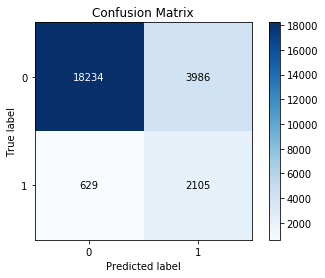

In [154]:
# plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_top_logit)
plt.show()

In [193]:
# calculate proformance metrics
cm_matrix = confusion_matrix(y_test, y_pred_top_logit)
tn, fp, fn, tp = cm_matrix.ravel()
accuracy = (tn+tp)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp /(tp+fn)
f1 = (2*precision*recall)/(precision+recall)
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)
print("Accuracy: {:0.2f}:".format(accuracy))
print("Precision: {:0.2f}:".format(precision))
print("Recall: {:0.2f}:".format(recall))
print("F1 Score: {:0.2f}:".format(f1))

True Negatives:  18234
False Positives:  3986
False Negatives:  629
True Positives:  2105
Accuracy: 0.82:
Precision: 0.35:
Recall: 0.77:
F1 Score: 0.48:


In [155]:
# print classification report
print(classification_report(y_test, y_pred_top_logit))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     22220
           1       0.35      0.77      0.48      2734

   micro avg       0.82      0.82      0.82     24954
   macro avg       0.66      0.80      0.68     24954
weighted avg       0.90      0.82      0.84     24954



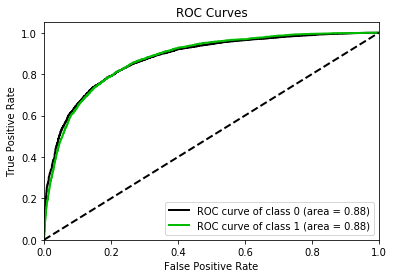

In [156]:
# plot ROC curves
skplt.metrics.plot_roc_curve(y_test, y_pred_prob_top_logit, curves = ('each_class'))
plt.show()

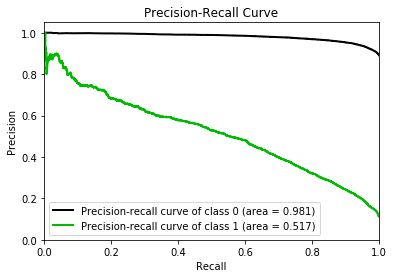

In [157]:
# plot Precision-Recall curve
skplt.metrics.plot_precision_recall_curve(y_test, y_pred_prob_top_logit, curves = ('each_class'))
plt.show()

In [208]:
# store proformance metrics
col_names = ['Model', 'Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC', 'Precision-Recall AUC']
metrics_refined = pd.DataFrame(columns = col_names)
logit_refined_metric = {'Model': 'Refined Logistic Regression', 'Precision': 0.35, 'Recall': 0.77, 
                'F1': 0.48, 'Accuracy': 0.82, 'ROC AUC': 0.88, 'Precision-Recall AUC': 0.52}
metrics_refined.loc[len(metrics)] = logit_refined_metric
metrics_refined

,Model,Precision,Recall,F1,Accuracy,ROC AUC,Precision-Recall AUC
2,Refined Logistic Regression,0.35,0.77,0.48,0.82,0.88,0.52


## Machine Learning Model - Refined Random Forests

In [195]:
# create a refined Random Forest model
refined_rf = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced', random_state = 12345, max_features=None)

In [196]:
# train the model on training data
refined_rf.fit(X_train_top_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=12345, verbose=0, warm_start=False)

In [210]:
# predict test data
y_pred_top_rf = refined_rf.predict(X_test_top_std)
y_pred_prob_top_rf = refined_rf.predict_proba(X_test_top_std)

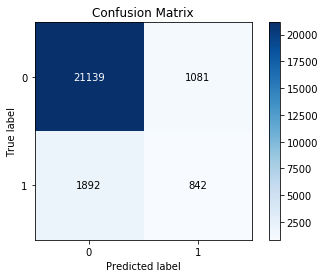

In [211]:
# plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_top_rf)
plt.show()

In [201]:
# calculate proformance metrics
cm_matrix = confusion_matrix(y_test, y_pred_top_rf)
tn, fp, fn, tp = cm_matrix.ravel()
accuracy = (tn+tp)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp /(tp+fn)
f1 = (2*precision*recall)/(precision+recall)
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)
print("Accuracy: {:0.2f}:".format(accuracy))
print("Precision: {:0.2f}:".format(precision))
print("Recall: {:0.2f}:".format(recall))
print("F1 Score: {:0.2f}:".format(f1))

True Negatives:  21139
False Positives:  1081
False Negatives:  1892
True Positives:  842
Accuracy: 0.88:
Precision: 0.44:
Recall: 0.31:
F1 Score: 0.36:


In [202]:
# print classification report
print(classification_report(y_test, y_pred_top_rf))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     22220
           1       0.44      0.31      0.36      2734

   micro avg       0.88      0.88      0.88     24954
   macro avg       0.68      0.63      0.65     24954
weighted avg       0.87      0.88      0.87     24954



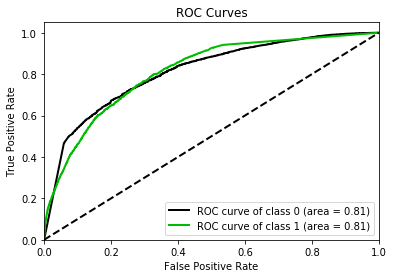

In [203]:
# plot ROC curves
skplt.metrics.plot_roc_curve(y_test, y_pred_prob_top_rf, curves = ('each_class'))
plt.show()

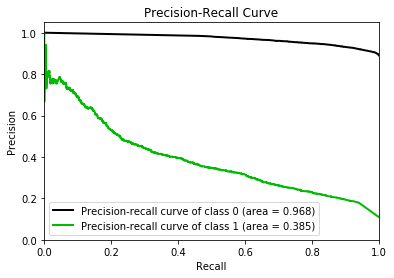

In [204]:
# plot Precision-Recall curve
skplt.metrics.plot_precision_recall_curve(y_test, y_pred_prob_top_rf, curves = ('each_class'))
plt.show()

In [209]:
# store proformance metrics
rf_refined_metric = {'Model': 'Refined Random Forests', 'Precision': 0.44, 'Recall': 0.31, 
                'F1': 0.36, 'Accuracy': 0.88, 'ROC AUC': 0.81, 'Precision-Recall AUC': 0.39}
metrics_refined.loc[len(metrics_refined)] = rf_refined_metric
metrics_refined

,Model,Precision,Recall,F1,Accuracy,ROC AUC,Precision-Recall AUC
2,Refined Logistic Regression,0.35,0.77,0.48,0.82,0.88,0.52
1,Refined Random Forests,0.44,0.31,0.36,0.88,0.81,0.39


# Conclusion

The major difference between machine learning and classical statistics is their purpose. Machine learning models are designed to make the most accurate predictions possible. Classical statistical models are designed for inference about the relationships between variables. 

While there is room for improvement in the proformance of machine learning for the cirrhosis study, machine learning models can complement classical statistical models and have promising potential for complicated problems.